In [1]:
# import required packages
import cv2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import scipy


In [2]:
# Initialize image data generator with rescaling
train_data_gen = ImageDataGenerator(rescale=1./255)
validation_data_gen = ImageDataGenerator(rescale=1./255)

In [3]:
# Preprocess all test images
train_generator = train_data_gen.flow_from_directory(
        'data/train',
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

# Preprocess all train images
validation_generator = validation_data_gen.flow_from_directory(
        'data/test',
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

Found 24282 images belonging to 5 classes.
Found 5937 images belonging to 5 classes.


In [4]:
# create model structure
emotion_model = Sequential()

emotion_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
emotion_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Flatten())
emotion_model.add(Dense(1024, activation='relu'))
emotion_model.add(Dropout(0.5))
emotion_model.add(Dense(5, activation='softmax'))

cv2.ocl.setUseOpenCL(False)

emotion_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])


In [5]:
# Train the model using fit_generator
emotion_model_info = emotion_model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

Epoch 1/50


C:\Users\ashut\AppData\Local\Temp\ipykernel_16412\560572671.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  emotion_model_info = emotion_model.fit_generator(




380/380 [==============================] - 88s 228ms/step - loss: 1.5509 - accuracy: 0.3144 - val_loss: 1.4258 - val_accuracy: 0.4206
Epoch 2/50
380/380 [==============================] - 78s 206ms/step - loss: 1.3655 - accuracy: 0.4357 - val_loss: 1.2867 - val_accuracy: 0.4859
Epoch 3/50
380/380 [==============================] - 76s 200ms/step - loss: 1.2667 - accuracy: 0.4868 - val_loss: 1.2001 - val_accuracy: 0.5284
Epoch 4/50
380/380 [==============================] - 88s 232ms/step - loss: 1.1952 - accuracy: 0.5205 - val_loss: 1.1440 - val_accuracy: 0.5437
Epoch 5/50
380/380 [==============================] - 86s 227ms/step - loss: 1.1418 - accuracy: 0.5441 - val_loss: 1.0924 - val_accuracy: 0.5688
Epoch 6/50
380/380 [==============================] - 85s 223ms/step - loss: 1.0922 - accuracy: 0.5654 - val_loss: 1.0610 - val_accuracy: 0.5809
Epoch 7/50
380/380 [==============================] - 85s 223ms/step - loss: 1.0545 - accuracy: 0.5820 - val_loss: 1.0329 - val_accuracy: 0

In [6]:
# save model structure in jason file
model_json = emotion_model.to_json()
with open("emotion_model.json", "w") as json_file:
    json_file.write(model_json)

In [7]:
# save trained model weight in .h5 file
emotion_model.save_weights('emotion_model.h5')




Loaded model from disk
Found 5937 images belonging to 5 classes.


C:\Users\ashut\AppData\Local\Temp\ipykernel_12516\872315823.py:32: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = emotion_model.predict_generator(test_generator)


-----------------------------------------------------------------
[[142 323 172 207 116]
 [251 582 346 391 255]
 [169 383 234 255 175]
 [165 348 211 256 159]
 [128 267 151 152  99]]


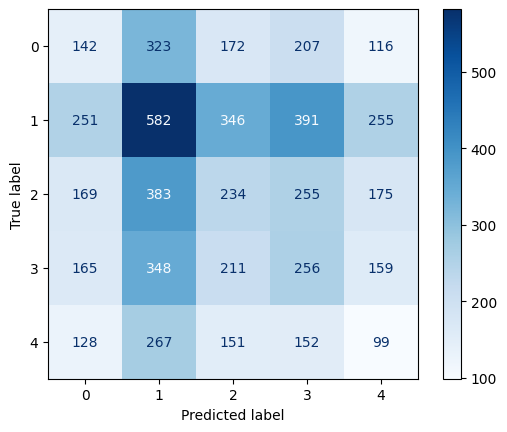

-----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.17      0.15      0.16       960
           1       0.31      0.32      0.31      1825
           2       0.21      0.19      0.20      1216
           3       0.20      0.22      0.21      1139
           4       0.12      0.12      0.12       797

    accuracy                           0.22      5937
   macro avg       0.20      0.20      0.20      5937
weighted avg       0.22      0.22      0.22      5937



In [1]:

import numpy as np
from keras.models import model_from_json
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay


emotion_dict = {0: "Angry", 1: "Happy", 2: "Neutral", 3: "Sad", 4: "Surprised"}

# load json and create model
json_file = open('emotion_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
emotion_model = model_from_json(loaded_model_json)

# load weights into new model
emotion_model.load_weights("emotion_model.h5")
print("Loaded model from disk")

# Initialize image data generator with rescaling
test_data_gen = ImageDataGenerator(rescale=1./255)

# Preprocess all test images
test_generator = test_data_gen.flow_from_directory(
        'data/test',
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

# do prediction on test data
predictions = emotion_model.predict_generator(test_generator)

# see predictions
# for result in predictions:
#     max_index = int(np.argmax(result))
#     print(emotion_dict[max_index])

print("-----------------------------------------------------------------")
# confusion matrix
c_matrix = confusion_matrix(test_generator.classes, predictions.argmax(axis=1))
print(c_matrix)
cm_display = ConfusionMatrixDisplay(confusion_matrix=c_matrix, display_labels=emotion_dict)
cm_display.plot(cmap=plt.cm.Blues)
plt.show()

# Classification report
print("-----------------------------------------------------------------")
print(classification_report(test_generator.classes, predictions.argmax(axis=1)))




